In [ ]:
# TODO: change the dataset sinthetic dataset. 
# not use pymc3 use pymc
# The notebook for Lecture 5.04.2023 is from pymc
# TODO: Modify this notebook to apply bayesian multilinear regression to boston housing dataset.

# Robust Linear Regression

This example has been lifted from the [PyMC Docs](https://docs.pymc.io/notebooks/GLM-robust.html), and adapted to for Bambi by Tyler James Burch ([\@tjburch](https://github.com/tjburch) on GitHub).

Many toy datasets circumvent problems that practitioners run into with real data. Specifically, the assumption of normality can be easily violated by outliers, which can cause havoc in traditional linear regression. One way to navigate this is through _robust linear regression_, outlined in this example.

First load modules and set the RNG for reproducibility.

**Exercise: Modify this notebook to apply bayesian multilinear regression to boston housing dataset.**

In [ ]:
!pip3 install bambi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 KB 5.3 MB/s eta 0:00:00


In [ ]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
az.style.use("arviz-darkgrid")
np.random.seed(1111)

Next, generate pseudodata. The bulk of the data will be linear with noise distributed normally, but additionally several outliers will be interjected.

In [ ]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

# Add outliers
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

data = pd.DataFrame({
    "x": x_out, 
    "y": y_out
})

Plot this data. The three data points in the top left are the interjected data.

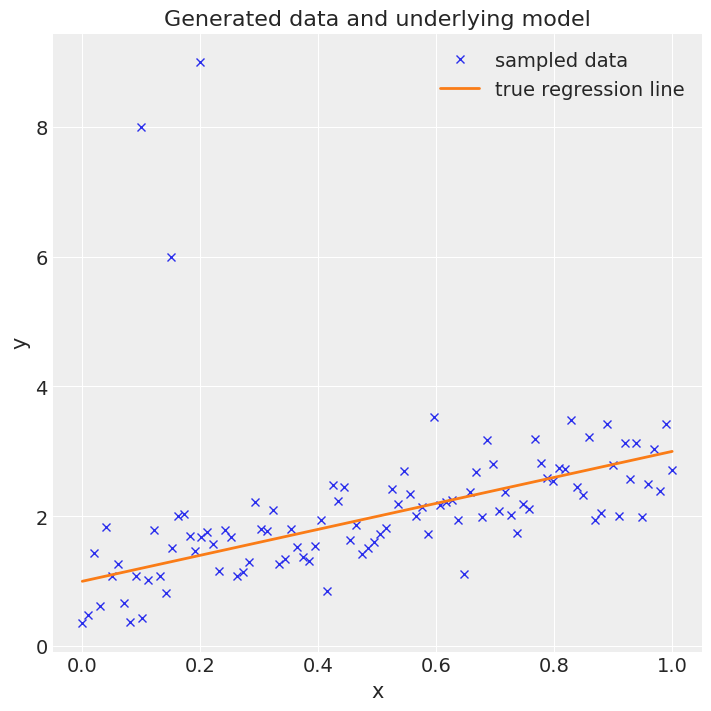

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

To highlight the problem, first fit a standard normally-distributed linear regression.

In [ ]:
# Note, "gaussian" is the default argument for family. Added to be explicit. 
gauss_model = bmb.Model("y ~ x", data, family="gaussian")
gauss_fitted = gauss_model.fit(draws=2000, idata_kwargs={"log_likelihood": True})
gauss_model.predict(gauss_fitted, kind="pps")

In [ ]:
az.summary(gauss_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.531,0.227,1.104,1.942,0.003,0.002,5931.0,3176.0,1.0
x,1.206,0.398,0.514,2.014,0.005,0.004,5492.0,3123.0,1.0
y_sigma,1.186,0.084,1.029,1.336,0.001,0.001,5695.0,2994.0,1.0
y_mean[0],1.531,0.227,1.104,1.942,0.003,0.002,5931.0,3176.0,1.0
y_mean[1],1.543,0.223,1.122,1.948,0.003,0.002,5934.0,3176.0,1.0
...,...,...,...,...,...,...,...,...,...
y_mean[98],2.724,0.231,2.299,3.159,0.003,0.002,5411.0,3103.0,1.0
y_mean[99],2.737,0.235,2.301,3.174,0.003,0.002,5420.0,3127.0,1.0
y_mean[100],1.651,0.194,1.294,2.016,0.003,0.002,5976.0,3029.0,1.0
y_mean[101],1.712,0.178,1.386,2.050,0.002,0.002,6015.0,2836.0,1.0


Remember, the true intercept was 1, the true slope was 2. The recovered intercept is much higher, and the slope is much lower, so the influence of the outliers is apparent.

Visually, looking at the recovered regression line and posterior predictive HDI highlights the problem further.

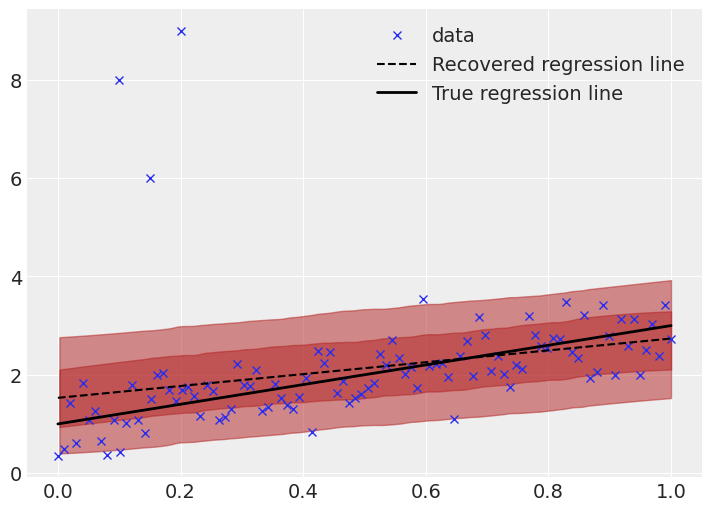

In [ ]:
plt.figure(figsize=(7, 5))
# Plot Data
plt.plot(x_out, y_out, "x", label="data")
# Plot recovered linear regression
x_range = np.linspace(min(x_out), max(x_out), 2000)
y_pred = gauss_fitted.posterior.x.mean().item() * x_range + gauss_fitted.posterior.Intercept.mean().item()
plt.plot(x_range, y_pred, 
         color="black",linestyle="--",
         label="Recovered regression line"
        )
# Plot HDIs
for interval in [0.38, 0.68]:
    az.plot_hdi(x_out, gauss_fitted.posterior_predictive.y, 
                hdi_prob=interval, color="firebrick")
# Plot true regression line
plt.plot(x, true_regression_line, 
        label="True regression line", lw=2.0, color="black")
plt.legend(loc=0);


The recovered regression line, as well as the $0.5\sigma$ and $1\sigma$ bands are shown. 

Clearly there is skew in the fit. At lower $x$ values, the regression line is far higher than the true line. This is a result of the outliers, which cause the model to assume a higher value in that regime.

Additionally the uncertainty bands are too wide (remember, the $1\sigma$ band ought to cover 68% of the data, while here it covers most of the points). Due to the small probability mass in the tails of a normal distribution, the outliers have an large effect, causing the uncertainty bands to be oversized. 

Clearly, assuming the data are distributed normally is inducing problems here. Bayesian robust linear regression forgoes the normality assumption by instead using a Student T distribution to describe the distribution of the data. The Student T distribution has thicker tails, and by allocating more probability mass to the tails, outliers have a less strong effect.

Comparing the two distributions,

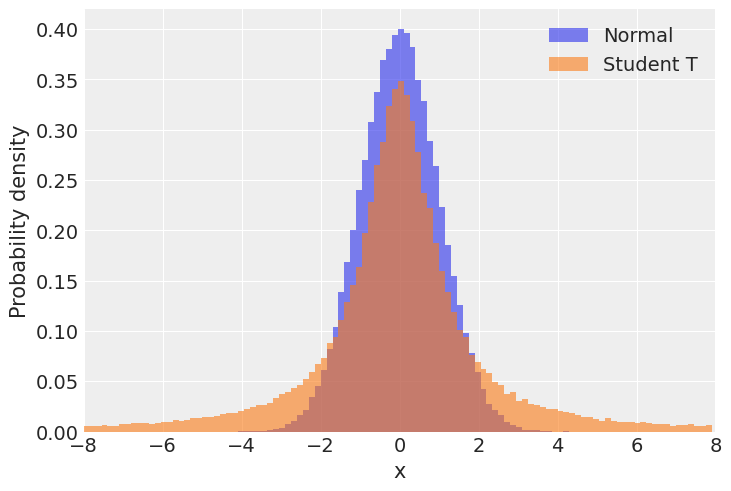

In [ ]:
normal_data = np.random.normal(loc=0, scale=1, size=100_000)
t_data = np.random.standard_t(df=1, size=100_000)

bins = np.arange(-8,8,0.15)
plt.hist(normal_data, 
         bins=bins, density=True,
         alpha=0.6,
         label="Normal"
        )
plt.hist(t_data, 
         bins=bins,density=True,
         alpha=0.6,
         label="Student T"
        )
plt.xlabel("x")
plt.ylabel("Probability density")
plt.xlim(-8,8)
plt.legend()

As we can see, the tails of the Student T are much larger, which means values far from the mean are more likely when compared to the normal distribution.

The T distribution is specified by a number of degrees of freedom ($\nu$). In [`numpy.random.standard_t`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.standard_t.html) this is the parameter `df`, in the [pymc T distribution](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.StudentT), it's `nu`. It is constrained to real numbers greater than 0. As the degrees of freedom increase, the probability in the tails Student T distribution decrease. In the limit of $\nu \rightarrow + \infty$, the Student T distribution is a normal distribution. Below, the T distribution is plotted for various $\nu$.

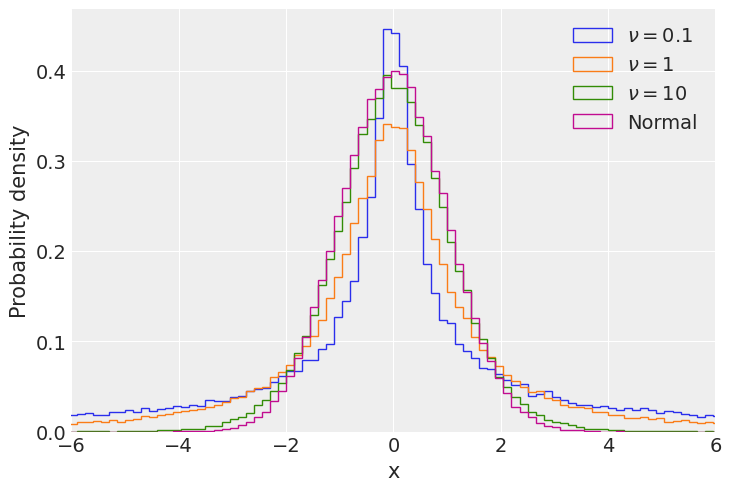

In [ ]:
bins = np.arange(-8,8,0.15)
for ndof in [0.1, 1, 10]:

    t_data = np.random.standard_t(df=ndof, size=100_000)

    plt.hist(t_data, 
             bins=bins,density=True,
             label=f"$\\nu = {ndof}$",
             histtype="step"
            )
plt.hist(normal_data, 
         bins=bins, density=True,
         histtype="step",
         label="Normal"
        )    
    
plt.xlabel("x")
plt.ylabel("Probability density")
plt.xlim(-6,6)
plt.legend()

In Bambi, the way to specify a regression with Student T distributed data is by passing `"t"` to the `family` parameter of a Model.

In [ ]:
t_model = bmb.Model("y ~ x", data, family="t")
t_fitted = t_model.fit(draws=2000, idata_kwargs={"log_likelihood": True})
t_model.predict(t_fitted, kind="pps")

In [ ]:
az.summary(t_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.995,0.110,0.785,1.201,0.002,0.001,5128.0,3208.0,1.0
x,1.899,0.192,1.516,2.236,0.003,0.002,5502.0,3130.0,1.0
y_sigma,0.405,0.045,0.317,0.485,0.001,0.001,3769.0,3092.0,1.0
y_nu,2.587,0.603,1.551,3.689,0.010,0.007,3810.0,3205.0,1.0
y_mean[0],0.995,0.110,0.785,1.201,0.002,0.001,5128.0,3208.0,1.0
...,...,...,...,...,...,...,...,...,...
y_mean[98],2.874,0.106,2.677,3.071,0.001,0.001,5179.0,3115.0,1.0
y_mean[99],2.893,0.108,2.694,3.093,0.001,0.001,5187.0,3131.0,1.0
y_mean[100],1.185,0.094,1.006,1.360,0.001,0.001,5025.0,3209.0,1.0
y_mean[101],1.280,0.086,1.111,1.435,0.001,0.001,4960.0,3182.0,1.0


Note the new parameter in the model, `y_nu`. This is the aforementioned degrees of freedom. If this number were very high, we would expect it to be well described by a normal distribution. However, the HDI of this spans from 1.5 to 3.7, meaning that the tails are much heavier than a normal distribution. As a result of the heavier tails, `y_sigma` has also dropped precipitously from the normal model, meaning the oversized uncertainty bands from above have shrunk.


Comparing the extracted values of the two models,

In [ ]:
def get_slope_intercept(mod):
    return (
        mod.posterior.x.mean().item(),
        mod.posterior.Intercept.mean().item()
    )
gauss_slope, gauss_int = get_slope_intercept(gauss_fitted)
t_slope, t_int = get_slope_intercept(t_fitted)

pd.DataFrame({
    "Model":["True","Normal","T"],
    "Slope":[2, gauss_slope, t_slope],
    "Intercept": [1, gauss_int, t_int]
}).set_index("Model").T.round(decimals=2)

Model,True,Normal,T
Slope,2.0,1.21,1.90
Intercept,1.0,1.53,0.99


Here we can see the mean recovered values of both the slope and intercept are far closer to the true values using the robust regression model compared to the normally distributed one.

Visually comparing the robust regression line,

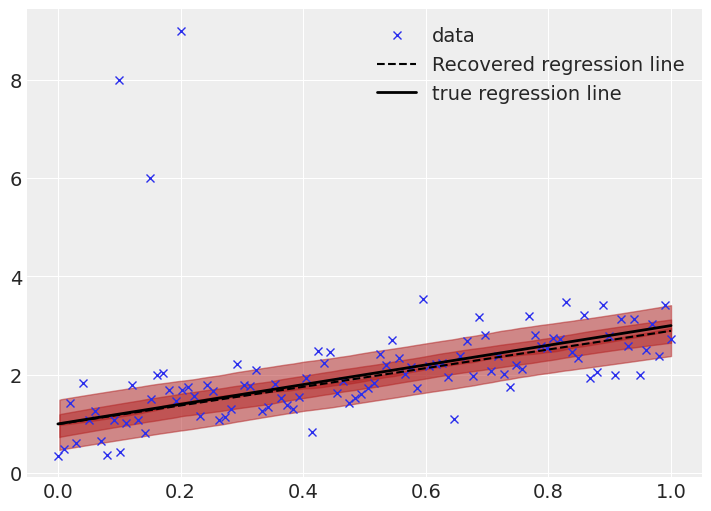

In [ ]:
plt.figure(figsize=(7, 5))
# Plot Data
plt.plot(x_out, y_out, "x", label="data")
# Plot recovered robust linear regression
x_range = np.linspace(min(x_out), max(x_out), 2000)
y_pred = t_fitted.posterior.x.mean().item() * x_range + t_fitted.posterior.Intercept.mean().item()
plt.plot(x_range, y_pred, 
         color="black",linestyle="--",
         label="Recovered regression line"
        )
# Plot HDIs
for interval in [0.05, 0.38, 0.68]:
    az.plot_hdi(x_out, t_fitted.posterior_predictive.y, 
                hdi_prob=interval, color="firebrick")
# Plot true regression line
plt.plot(x, true_regression_line, 
        label="true regression line", lw=2.0, color="black")
plt.legend(loc=0)

This is much better. The true and recovered regression lines are much closer, and the uncertainty bands are appropriate sized. The effect of the outliers is not _entirely_ gone, the recovered line still slightly differs from the true line, but the effect is far smaller, which is a result of the Student T likelihood function ascribing a higher probability to outliers than the normal distribution. Additionally, this inference is based on sampling methods, so it is expected to have small differences (especially given a relatively small number of samples).

Last, another way to evaluate the models is to compare based on Leave-one-out Cross-validation (LOO), which provides an estimate of accuracy on out-of-sample predictions.

Leave-One-Out Cross-Validation (LOO) is a type of cross-validation technique used to evaluate the performance of a machine learning model. In LOO, the dataset is divided into n subsets, and the model is trained n times, each time leaving out one of the subsets for testing and using the rest for training. This means that for each iteration, only a single data point is used for testing, and the remaining data points are used for training.

The advantage of LOO is that it provides an unbiased estimate of the model's generalization error since each data point is used for testing exactly once. However, the downside is that it can be computationally expensive, especially for large datasets, since the model needs to be trained n times.

LOO is often used when the dataset is small or when there is a high cost associated with collecting additional data. It is also commonly used in the evaluation of regression models since it provides a good estimate of the model's prediction error. Overall, LOO is a useful technique for evaluating the performance of a machine learning model and is a valuable tool in the data scientist's toolbox.

ELPD-LOO (expected log pointwise predictive density using leave-one-out cross-validation) is a measure used in Bayesian statistics to compare the predictive accuracy of different models.

It involves fitting the model to all but one of the data points and then using the fitted model to predict the left-out data point. This process is repeated for each data point, and the resulting predictions are used to calculate the log pointwise predictive density (LPD).

The ELPD-LOO is the expected value of the LPD across all possible leave-one-out combinations. It provides a way to estimate the out-of-sample predictive accuracy of a model, taking into account both model complexity and goodness-of-fit.

ELPD-LOO is often used to compare different models fit to the same data set, with a lower ELPD-LOO indicating better predictive accuracy.

The p_loo measure (also known as Pareto smoothed importance sampling leave-one-out cross-validation) is a statistical method used for model selection and comparison in Bayesian data analysis. It is particularly useful for evaluating the out-of-sample predictive performance of a Bayesian model.

In LOO (leave-one-out) cross-validation, the data set is repeatedly partitioned into training and testing sets, with one observation removed at a time to form the testing set. The model is then fit on the training set and used to predict the removed observation in the testing set. This process is repeated for each observation in the data set, and the resulting predictive accuracy is used to evaluate the model.

The p_loo measure is a way of estimating the out-of-sample predictive accuracy of a Bayesian model using importance sampling. It is defined as the expected log pointwise predictive density of a new data point, averaged over all possible training sets with one observation removed. This measure can be used to compare the predictive performance of different models, and to identify which variables are most important for making accurate predictions. A lower p_loo value indicates better predictive performance.

The p_loo measure is calculated using posterior samples from the model, and can be computed using various software packages for Bayesian analysis, such as Stan, JAGS, or PyMC3.

"SE" standard error and 
"DSE" typically stands for "deviation from standard error," which is a statistical measure used in regression analysis to evaluate the goodness of fit of a model. However, I'm not sure what you mean by "LOO."

The warning you are referring to is related to the Pareto diagnostics in the loo package. The Pareto diagnostics indicate that for some observations, the leave-one-out posteriors are different enough from the full posterior that importance-sampling is not able to correct the difference

In [ ]:
models = {
    "gaussian": gauss_fitted,
    "Student T": t_fitted
}
df_compare = az.compare(models)
df_compare

/usr/local/lib/python3.9/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student T,0,-101.677321,5.527944,0.000000,1.0,14.885440,0.000000,False,log
gaussian,1,-171.243763,13.222263,69.566442,0.0,29.098323,17.372273,True,log


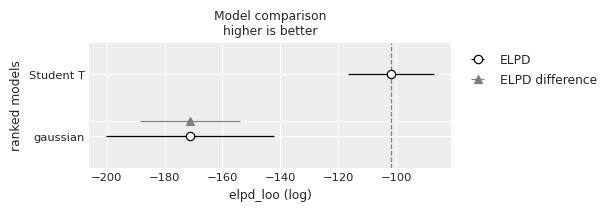

In [ ]:
az.plot_compare(df_compare, insample_dev=False)

Here it is quite obvious that the Student T model is much better, due to having a clearly larger value of LOO.